# Grokking

This notebook try to reimplement the grokking effect found in the paper arXiv:2201.02177v1. It's not a direct reimplementation since some simplification are made.

# Imports & device selection

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda" :
    print('Using CUDA device', torch.cuda.get_device_name(0))
else :
    print('Using CPU')

Using CUDA device NVIDIA GeForce GTX 1650 with Max-Q Design


# Hyperparameters & operations

In [2]:
p = 97 # Prime number used by the modulo

N_EPOCHS = 500
BATCH_SIZE = 64
TRAINSET_SIZE = 0.7
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1

We define now every binary operations shown in the paper

In [3]:
def op_1(x, y) :
    return (x + y) % p

def op_2(x, y) :
    return (x - y) % p

In [4]:
op = op_1

# Model

Since we are trying here to replicate the grokking effect, we won't use the same model. Here we only use token for numbers (1-hot vectors) and a feed-forward decoder (while the paper presents a decoder only transformer).

In [5]:
class GrokkingModel(torch.nn.Module) :
    def __init__(self, op=op, emb_dim=128) :
        super().__init__()
        self.op = op
        self.emb1 = nn.Embedding(p, emb_dim)
        self.emb2 = nn.Embedding(p, emb_dim)

        self.feed = nn.Sequential(nn.Linear(2 * emb_dim, emb_dim), nn.ReLU(), nn.Linear(emb_dim, p))

    def forward(self, x, y) :
        # dim x = (batch)
        x_emb = self.emb1(x)
        y_emb = self.emb2(y)

        # dim x_emb = (batch, emb_dim)

        emb = torch.cat((x_emb, y_emb), dim=1)
        return self.feed(emb)

# Experiment

In [6]:
model = GrokkingModel()
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

## Dataset creation

In [7]:
from sklearn.model_selection import train_test_split

x = torch.arange(p, device=device)
y = torch.arange(p, device=device)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
grid_x.unsqueeze_(-1)
grid_y.unsqueeze_(-1)

dataset_tens = op(grid_x,grid_y)
dataset_tens = torch.cat((grid_x, grid_y, dataset_tens), dim=2)
dataset_tens = torch.flatten(dataset_tens, end_dim=1)

trainset, valset = train_test_split(dataset_tens, train_size=TRAINSET_SIZE, shuffle=True)

train_dataset = torch.utils.data.TensorDataset(trainset)
val_dataset = torch.utils.data.TensorDataset(valset)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataloader))

103


In [8]:
def validation_acc() :
    with torch.no_grad() :
        x, y, res = valset[:,0], valset[:,1], valset[:,2]
        pred = model(x, y)
        acc = (pred.argmax(dim=1) == res).type(torch.DoubleTensor).mean().item()
        return acc

## Training loop

In [9]:
t_accs, v_accs = [], []

model.train()
for _ in tqdm(range(N_EPOCHS)) :
    train_acc = 0
    for inp in train_dataloader :
        inp = inp[0]
        x, y, res = inp[:,0], inp[:,1], inp[:,2]
        optimizer.zero_grad()

        
        pred = model(x, y)
        
        loss = criterion(pred, res)
        loss.backward()
        optimizer.step()

        train_acc += (pred.argmax(dim=1) == res).sum().item()

    t_accs.append(train_acc / len(train_dataset))
    v_accs.append(validation_acc())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.56it/s]


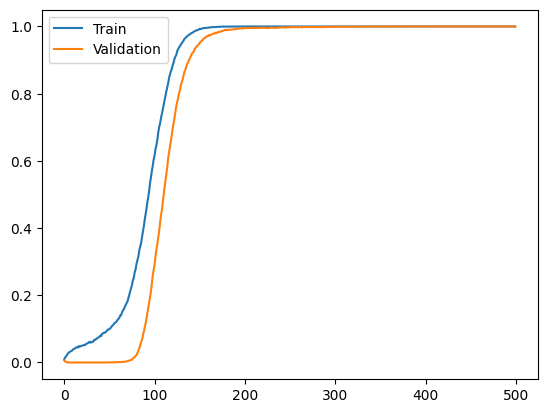

In [10]:
plt.plot(t_accs, label='Train')
plt.plot(v_accs, label='Validation')
plt.legend()
plt.show()